## isolated clustering including recombination of mini-cluster for hpc run 

Comments:

By using the read weighted edge list from a csv file, it saves much space on self.graph

This will for specific batch number and hop-layer number

In [4]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
import copy
import csv
import os
import sys
import torch
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm_notebook as tqdm
import pickle
import shutil

from utils import *


In [6]:
import inspect
import torch
from torch_geometric.utils import scatter_

import math
import random

from torch.nn import Parameter
from torch_scatter import scatter_add
# from torch_geometric.nn import MessagePassing
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import add_remaining_self_loops

### ====================== Establish a GCN based model ========================
class ListModule(torch.nn.Module):
    """
    Abstract list layer class.
    """
    def __init__(self, *args):
        """
        Module initializing.
        """
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        """
        Getting the indexed layer.
        """
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        """
        Iterating on the layers.
        """
        return iter(self._modules.values())

    def __len__(self):
        """
        Number of layers.
        """
        return len(self._modules)


class Net(torch.nn.Module):
    def __init__(self, in_channels, out_channels, input_layers = [16, 16], dropout=0.3):
        """
        input layers: list of integers
        dropout: probability of droping out 
        """
        super(Net, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        self.setup_layers()

    def setup_layers(self):
        """
        Creating the layes based on the args.
        """
        self.layers = []
        self.input_layers = [self.in_channels] + self.input_layers + [self.out_channels]
        for i, _ in enumerate(self.input_layers[:-1]):
            self.layers.append(GCNConv(self.input_layers[i],self.input_layers[i+1]))
        self.layers = ListModule(*self.layers)

    # change the dropout positions: 
    def forward(self, edge_index, features):
        if len(self.layers) > 1:
            for i in range(len(self.layers)-1):
                features = F.relu(self.layers[i](features, edge_index))
#                 if i>0:
                features = F.dropout(features, p = self.dropout, training = self.training)
                    
            features = self.layers[len(self.layers)-1](features, edge_index)
        else:
            features = self.layers[0](features, edge_index)    # for a single layer case

        predictions = F.log_softmax(features, dim=1)
        return predictions

### Partition GCN

In [11]:

import metis
import random
import numpy as np
import networkx as nx
from sklearn.model_selection import train_test_split
from itertools import chain

class ClusteringMachine(object):
    """
    Clustering the graph, feature set and label. Performed on the CPU side
    """
    def __init__(self, edge_index, features, label, tmp_folder = './tmp/', info_folder = './info/'):
        """
        :param edge_index: COO format of the edge indices.
        :param features: Feature matrix (ndarray).
        :param label: label vector (ndarray).
        :tmp_folder(string): the path of the folder to contain all the clustering information files
        """
        self.features = features
        self.label = label
        self._set_sizes()
        self.edge_index = edge_index
        # store the information folder for memory tracing
        self.tmp_folder = tmp_folder
        self.info_folder = info_folder
        
        tmp = edge_index.t().numpy().tolist()
        self.graph = nx.from_edgelist(tmp)
        
    def _set_sizes(self):
        """
        Setting the feature and class count.
        """
        self.node_count = self.features.shape[0]
        self.feature_count = self.features.shape[1]    # features all always in the columns
        self.label_count = len(np.unique(self.label.numpy()) )
        
    # 1) first use different clustering method, then split each cluster into train, test and validation nodes, split edges
    def split_whole_nodes_edges_then_cluster(self, test_ratio, validation_ratio, train_batch_num = 2):
        """
            Only split nodes
            First create train-test splits, then split train and validation into different batch seeds
            Input:  
                1) ratio of test, validation
                2) partition number of train nodes, test nodes, validation nodes
            Output:
                1) self.sg_validation_nodes_global, self.sg_train_nodes_global, self.sg_test_nodes_global
        """
        self.train_batch_num = train_batch_num
        relative_test_ratio = (test_ratio) / (1 - validation_ratio)
        
        # first divide the nodes for the whole graph, result will always be a list of lists 
        model_nodes_global, self.valid_nodes_global = train_test_split(list(self.graph.nodes()), test_size = validation_ratio)
        train_nodes_global, test_nodes_global = train_test_split(model_nodes_global, test_size = relative_test_ratio)
        
#         self.sg_train_nodes_global = self.random_clustering(train_nodes_global, train_batch_num)
#         self.sg_validation_nodes_global = self.random_clustering(valid_nodes_global, valid_batch_num)
#         self.sg_test_nodes_global = self.random_clustering(test_nodes_global, test_batch_num)
        self.sg_train_nodes_global = self.metis_clustering(self.graph.subgraph(train_nodes_global), train_batch_num)
#         self.sg_test_nodes_global = self.metis_clustering(test_nodes_global, test_batch_num)
    
    # just allocate each node to arandom cluster, store the membership inside each dict
    def random_clustering(self, target_nodes, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated
            Output: 
                1) membership of each node
        """
        # randomly divide into two clusters
        nodes_order = [node for node in target_nodes]
        random.shuffle(nodes_order)
        n = (len(nodes_order) + partition_num - 1) // partition_num
        partition_list = [nodes_order[i * n:(i + 1) * n] for i in range(partition_num)]
#         cluster_membership = {node : i for i, node_list in enumerate(partition_list) for node in node_list}
        cluster_nodes_global = {i : node_list for i, node_list in enumerate(partition_list)}
        
        return cluster_nodes_global

    def metis_clustering(self, target_graph, partition_num):
        """
            Random clustering the nodes.
            Input: 
                1) target_nodes: list of node 
                2) partition_num: number of partition to be generated, must be greater than 1, otherwise crash
            Output: 
                1) membership of each node
        """
        (st, parts) = metis.part_graph(target_graph, partition_num)
        cluster_nodes_global = defaultdict(list)
        for node, cluster_id in enumerate(parts):
            cluster_nodes_global[cluster_id].append(node)
        return cluster_nodes_global

    # for use of validation on the whole graph as a whole in CPU-side memory
    def whole_batch_generate(self, batch_file_folder, test_nodes):
        """
            For use of testing the model: generate the needed tensors for testing in CPU-memory side
        """
        # store the global edges
        whole_nodes_global = sorted(self.graph.nodes())
        whole_edges_global = {edge for edge in self.graph.edges()}
        
        whole_edges_local = \
                       [ [ left, right ] for left, right in whole_edges_global ] + \
                       [ [ right, left ] for left, right in whole_edges_global ] + \
                       [ [i, i] for i in whole_nodes_global ]  
        
        # store local features and lables
        whole_features_local = self.features
        whole_labels_local = self.label

        # transform all the data to the tensor form
        whole_edges_local = torch.LongTensor(whole_edges_local).t()
        whole_features_local = torch.FloatTensor(whole_features_local)
        whole_labels_local = torch.LongTensor(whole_labels_local)
        whole_test_nodes_local = torch.LongTensor( sorted(test_nodes) )

        whole_batch_data = [whole_test_nodes_local, whole_edges_local, whole_features_local, whole_labels_local]

        batch_file_name = batch_file_folder + 'batch_whole'

        # store the batch files
        t0 = time.time()
        with open(batch_file_name, "wb") as fp:
            pickle.dump(whole_batch_data, fp)
        store_time = ((time.time() - t0) * 1000)
        print('*** Generate batch file for # {0} batch, writing the batch file costed {1:.2f} ms ***'.format("whole graph", store_time) )
    
    def mini_batch_divide_neighbor(self, accum_neighbor, partition_size):
        """
            accum_neighbor (set) : the total sampled neighbor of a specific cluster
            partition_size: the size of each cluster
            return  (a list of list ):  each cluster contains a certain number (partition_size) of nodes
        """
        partition_num = (len(accum_neighbor) + partition_size - 1) // partition_size
        if partition_num > 1:
            sampled_neighbor_group = self.metis_clustering(self.graph.subgraph(accum_neighbor), partition_num)
            sampled_neighbor_group = [list(val) for _, val in sampled_neighbor_group.items()]
        else:
            sampled_neighbor_group = [list(accum_neighbor)]
        return sampled_neighbor_group
    
    def mini_batch_neighbor_sample(self, target_seed, k, frac = 1):
        """
            This function is to generate the neighbors of the seed (either train nodes or validation nodes)
            params: cluster index, number of layer k, fraction of sampling from each neighbor layer
            input: 
                1) target_seed: this is the 0 layer inside self.neighbor
            output:
                1) neighbor: nodes global idx inside each layer of the batch
                2) accum_neighbor: accumulating neighbors , i.e. the final batch nodes
        """
        accum_neighbor = defaultdict(set)
        for cluster in target_seed.keys():
            neighbor = set(target_seed[cluster])  # first layer of the neighbor nodes of each cluster
            for layer in range(k):
                # first accumulate last layer
                accum_neighbor[cluster] |= neighbor
                tmp_level = set()
                for node in neighbor:
                    tmp_level |= set(self.graph.neighbors(node))  # the key here we are using self.graph, extract neighbor from the whole graph
                # add the new layer of neighbors
                tmp_level -= accum_neighbor[cluster]
                # each layer will only contains partial nodes from the previous layer
                neighbor = set(random.sample(tmp_level, int(len(tmp_level) * frac) ) ) if 0 < frac < 1 else tmp_level
    #                 print('layer ' + str(layer + 1) + ' : ', self.neighbor[cluster][layer+1])
            # the most outside layer: kth layer will be added:
            accum_neighbor[cluster] |= neighbor
            accum_neighbor[cluster] -= set(target_seed[cluster])  # only contains neighor, does not include train seeds
        return accum_neighbor
    
    def mini_batch_generate_tensor(self, sampled_neighbor_nodes, train_seed_nodes):
        """
            sampled_neighbor_nodes : selected neighbor nodes, to be combined with train seeds to form a train batch
        """
        train_batch_nodes = list(sampled_neighbor_nodes) + list(train_seed_nodes)
        batch_subgraph = self.graph.subgraph(train_batch_nodes)
            
         # first select all the overlapping nodes of the train nodes
        mini_nodes_global = sorted(node for node in batch_subgraph.nodes())

        # store the global edges
        mini_edges_global = {edge for edge in batch_subgraph.edges()}

        # map nodes from global index to local index
        mini_mapper = {node: i for i, node in enumerate(mini_nodes_global)}

        # store local index of batch nodes
        mini_nodes_local = [ mini_mapper[global_idx] for global_idx in train_seed_nodes ]

        # store local index of batch edges
        mini_edges_local = \
                       [ [ mini_mapper[edge[0]], mini_mapper[edge[1]] ] for edge in mini_edges_global ] + \
                       [ [ mini_mapper[edge[1]], mini_mapper[edge[0]] ] for edge in mini_edges_global ] 

        # store local features and lables
        mini_features = self.features[mini_nodes_global,:]
        mini_labels = self.label[mini_nodes_global]
        
        # record information 
        info_batch_node_size = len(mini_nodes_global)
        info_batch_edge_size = len(mini_edges_local) + info_batch_node_size  # add the self-edges

        mini_nodes_local = torch.LongTensor(mini_nodes_local)
        mini_edges_local = torch.LongTensor(mini_edges_local).t()
        mini_features = torch.FloatTensor(mini_features)
        mini_labels = torch.LongTensor(mini_labels)

        minibatch_data = [mini_nodes_local, mini_edges_local, mini_features, mini_labels]
        
        return minibatch_data, info_batch_node_size, info_batch_edge_size
    
    def mini_batch_generate(self, batch_file_folder, target_seed, partition_size, k, fraction = 1.0, batch_range = (0, 1)):
        """
            create the mini-batch focused on the train nodes only, include a total of k layers of neighbors of the original training nodes
            k: number of layers of neighbors for each training node
            fraction: fraction of neighbor nodes in each layer to be considered
            Input:
                1) target_seed: global ids of the nodes for seed to generate the batch
                    usually one of (train_global, test_global_, validation_global)
            Output: all tensors which are gonna be used in the train, forward procedure
                local:
                    1) sg_mini_edges_local
                    2) self.sg_mini_train_edge_weight_local
                    3) self.sg_mini_train_nodes_local
                    4) self.sg_mini_train_features
                    5) self.sg_mini_train_labels
            
        """
        accum_neighbor = self.mini_batch_neighbor_sample(target_seed, k, frac = fraction)
        batch_start, batch_end = batch_range
        
        info_batch_node_size = {}
        info_batch_edge_size = {}
        batch_start, batch_end = batch_range
        for cluster in range(batch_start, batch_end):
            # main purpose is to avoid too large size of this batch_subgraph with too many intra-edges inside
            
            sampled_neighbor_group = self.mini_batch_divide_neighbor(accum_neighbor[cluster], partition_size)
            train_batch_tensor_group = [self.mini_batch_generate_tensor(sampled_neighbor_nodes, target_seed[cluster]) for sampled_neighbor_nodes in sampled_neighbor_group]
            
            info_batch_node_size[cluster] = [ele[1] for ele in train_batch_tensor_group]
            info_batch_edge_size[cluster] = [ele[2] for ele in train_batch_tensor_group]
            minibatch_data_group = [ele[0] for ele in train_batch_tensor_group]
            
            # store the batch files
            t0 = time.time()
            batch_file_name = batch_file_folder + 'batch_' + str(cluster)
            
            with open(batch_file_name, "wb") as fp:
                pickle.dump(minibatch_data_group, fp)
            store_time = ((time.time() - t0) * 1000)
            print('*** Generate batch file for # {0:3d} batch, writing the batch file costed {1:.2f} ms ***'.format(cluster, store_time) )
#             print('writing to the path: ', batch_file_name)
            
        return info_batch_node_size, info_batch_edge_size
    
    def save_info_dict(self, data, file_name, target_folder, header = 'key, value'):
        # output the batch size information as the csv file
#         os.makedirs(os.path.dirname(target_folder), exist_ok=True)
        target_file = target_folder + file_name
        with open(target_file, 'a', newline='\n') as fp:
            wr = csv.writer(fp, delimiter = ',')
            fp.write('\n')
            wr.writerow(header.split(','))
            for key, val in data.items():
                if isinstance(val, list):
                    wr.writerow([key+1] + val)
                else:
                    wr.writerow([key+1, val])
    
    def mini_batch_train_clustering(self, batch_folder, partition_size, k, fraction = 1.0, batch_range = (0, 1), info_folder = './info/', info_file = 'train_batch_size_info.csv'):
        data_type = 'train'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.info_train_batch_node_size, self.info_train_batch_edge_size  = self.mini_batch_generate(batch_file_folder, self.sg_train_nodes_global, partition_size, k, fraction = fraction, batch_range = batch_range)
        self.info_train_seed_size = {key : len(val) for key, val in self.sg_train_nodes_global.items()}
        
        self.save_info_dict(self.info_train_batch_node_size, info_file, info_folder, header = 'train_batch_node_id, train_batch_node_size')
        self.save_info_dict(self.info_train_batch_edge_size, info_file, info_folder, header = 'train_batch_edge_id, train_batch_edge_size')
        self.save_info_dict(self.info_train_seed_size, info_file, info_folder, header = 'train_seed_node_id, train_seed_node_size')
        
    def whole_validation_clustering(self, batch_folder, info_folder = './info/', info_file = 'validation_whole_size_info.csv'):
        data_type = 'validation'
        batch_file_folder = batch_folder + data_type + '/'
#         check_folder_exist(batch_file_folder)
        os.makedirs(os.path.dirname(batch_file_folder), exist_ok=True)
        
        self.whole_batch_generate(batch_file_folder, self.valid_nodes_global)        
        


#### Partition Graph with trainiing and testing

In [12]:
# from Custom_GCN_layer import Net
import time
from torch.autograd import Variable
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

class ClusterGCNTrainer_mini_Train(object):
    """
    Training a ClusterGCN.
    """
    def __init__(self, data_folder, in_channels, out_channels, input_layers = [32, 16], dropout=0.3):
        """
        :param in_channels, out_channels: input and output feature dimension
        :param clustering_machine:
        """  
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.test_device = torch.device("cpu")
        
        self.data_folder = data_folder
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.input_layers = input_layers
        self.dropout = dropout
        
        self.create_model()

    def create_model(self):
        """
        Creating a StackedGCN and transferring to CPU/GPU.
        """
#         print('used layers are: ', str(self.input_layers))
        self.model = Net(self.in_channels, self.out_channels, input_layers = self.input_layers, dropout = self.dropout)
        self.model = self.model.to(self.device)
    
    # call the forward function batch by batch
    def do_forward_pass(self, tr_train_nodes, tr_edges, tr_features, tr_target):
        """
        Making a forward pass with data from a given partition.
        :param cluster: Cluster index.
        :return average_loss: Average loss on the cluster.
        :return node_count: Number of nodes.
        """
        
        '''Target and features are one-one mapping'''
        # calculate the probabilites from log_sofmax
        predictions = self.model(tr_edges, tr_features)
        
        ave_loss = torch.nn.functional.nll_loss(predictions[tr_train_nodes], tr_target[tr_train_nodes])
        node_count = tr_train_nodes.shape[0]

        # for each cluster keep track of the counts of the nodes
        return ave_loss, node_count

    def update_average_loss(self, batch_average_loss, node_count, isolate = True):
        """
        Updating the average loss in the epoch.
        :param batch_average_loss: Loss of the cluster. 
        :param node_count: Number of nodes in currently processed cluster.
        :return average_loss: Average loss in the epoch.
        """
        self.accumulated_training_loss = self.accumulated_training_loss + batch_average_loss.item() * node_count
        if isolate:
            self.node_count_seen = self.node_count_seen + node_count
        average_loss = self.accumulated_training_loss / self.node_count_seen
        return average_loss

    # iterate through epoch and also the clusters
    def train_investigate_F1(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, output_period = 10, train_batch_num = 2, valid_batch_num = 2):
        """
            *** Periodically output the F1 score during training. After certain number of epochs ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
            output_period:  number of epochs after which output the F1 and accuray to investigate the model refining process
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()   #   set into train mode, only effective for certain modules such as dropout and batchNorm
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        investigate_f1 = {}
        investigate_accuracy = {}
        
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch_part in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            for cluster in train_clusters:
                # for each batch, we load once and train it for multiple epochs:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
                print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train
                
                t1 = time.time()
                tr_train_nodes = tr_train_nodes.to(self.device)
                tr_edges = tr_edges.to(self.device)
                tr_features = tr_features.to(self.device)
                tr_target = tr_target.to(self.device)
                
                self.time_train_load_data += (time.time() - t1) * 1000
                # train each batch for multiple epochs
                for mini_epoch in range(mini_epoch_num):
                    # record the current overall epoch index:
                    real_epoch_num = 1 + mini_epoch + mini_epoch_num * epoch_part # real_epoch_num starts from 0, therefore we add 1
                    
                    self.optimizer.zero_grad()
                    batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                    batch_ave_loss.backward()
                    self.optimizer.step()
                    ave_loss = self.update_average_loss(batch_ave_loss, node_count)
                    
                    # at this point finish a single train duration: update the parameter and calcualte the loss function
                    # periodically output the F1-score in the middle of the training process
                    if real_epoch_num % output_period == 0:
                        investigate_f1[real_epoch_num], investigate_accuracy[real_epoch_num] = self.batch_validate(valid_batch_num = valid_batch_num)
                        self.model.train()    # reset to the train mode
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
        return investigate_f1, investigate_accuracy

    # iterate through epoch and also the clusters
    def train(self, epoch_num=10, learning_rate=0.01, weight_decay = 0.01, mini_epoch_num = 1, train_batch_num = 2):
        """
            *** Training a model. ***
            epoch_num:  number of total training epoch number
            learning rate: learning rate during training
            weight_decay:  decay coefficients for the regularization
            mini_epoch_num:  number of epochs of repeating training after loading data on the GPU
        """
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        self.model.train()
        self.record_ave_training_loss = []
        self.time_train_load_data = 0
        
        epoch_partition = epoch_num // mini_epoch_num
        t0 = time.time()
        train_clusters = list(range(train_batch_num))
        for epoch in range(epoch_partition):
#             For test purpose, we let the clusters to follow specific order
            random.shuffle(train_clusters)
            self.node_count_seen = 0
            self.accumulated_training_loss = 0
            
            for cluster in train_clusters:
                # read in the train data from the pickle files
                batch_file_name = self.data_folder + 'train/batch_' + str(cluster)
                
                t2 = time.time()
                with open(batch_file_name, "rb") as fp:
                    minibatch_data_train_group = pickle.load(fp)
                read_time = (time.time() - t2) * 1000
                print('*** During training for # {0:3d} batch, reading batch file costed {1:.2f} ms ***'.format(cluster, read_time) )
                
                random.shuffle(minibatch_data_train_group)
                for minibatch_data_train in minibatch_data_train_group:
                    tr_train_nodes, tr_edges, tr_features, tr_target = minibatch_data_train

                    # for each cluster, we load once and train it for multiple epochs:
                    t1 = time.time()
                    tr_train_nodes = tr_train_nodes.to(self.device)
                    tr_edges = tr_edges.to(self.device)
                    tr_features = tr_features.to(self.device)
                    tr_target = tr_target.to(self.device)

                    self.time_train_load_data += (time.time() - t1) * 1000
                    # train each batch for multiple epochs
                    for mini_epoch in range(mini_epoch_num):
                        self.optimizer.zero_grad()
                        batch_ave_loss, node_count = self.do_forward_pass(tr_train_nodes, tr_edges, tr_features, tr_target)
                        batch_ave_loss.backward()
                        self.optimizer.step()
                        ave_loss = self.update_average_loss(batch_ave_loss, node_count)
            
            self.record_ave_training_loss.append(ave_loss)
        # convert to ms
        self.time_train_total = ((time.time() - t0) * 1000)
    
    
    def whole_cpu_validate(self):
        """
        Scoring the test and printing the F-1 score.
        """
        self.test_device = torch.device("cpu")
        test_model = self.model.to(self.test_device)
        test_model.eval()   # set into test mode, only effective for certain modules such as dropout and batchNorm
        
        batch_file_name = self.data_folder + 'validation/batch_whole'

        t2 = time.time()
        with open(batch_file_name, "rb") as fp:
            minibatch_data_validation = pickle.load(fp)
        read_time = (time.time() - t2) * 1000
        print('*** During validation for # {0} batch, reading batch file costed {1:.2f} ms ***'.format("whole graph", read_time) )

        valid_validation_nodes, valid_edges, valid_features, valid_target = minibatch_data_validation

        prediction = test_model(valid_edges, valid_features)
        # select the testing nodes predictions and real labels
        predictions = prediction[valid_validation_nodes].cpu().detach().numpy()
        targets = valid_target[valid_validation_nodes].cpu().detach().numpy()
        
        # along axis:    axis == 1
        predictions = predictions.argmax(1)  # return the indices of maximum probability 
        
        f1 = f1_score(targets, predictions, average="micro")
        accuracy = accuracy_score(targets, predictions)
#         print("\nTest F-1 score: {:.4f}".format(score))
        return (f1, accuracy)


### Use Trivial data

In [15]:
'''Trivial data'''
edge_index = torch.tensor([[0, 1, 1, 3, 1, 2, 4, 2, 4, 6, 6, 7, 7, 9, 2, 5, 9, 8], 
                           [1, 0, 3, 1, 2, 1, 2, 4, 6, 4, 7, 6, 9, 7, 5, 2, 8, 9]])
# features = torch.rand(10, 3)
features = torch.tensor([[0, 0], [0, 1], [0, 2], [0, 3], [0, 4],  
                           [0, 5], [0, 6], [0, 7], [0, 8], [0, 9]], dtype = torch.float)
# label = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
label = torch.tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0])
print(features, features.shape)

# set the tmp folder
# tmp_folder = './tmp/'
# check_folder_exist(tmp_folder)
# os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
# set the store clustering path
tmp_folder = './res_save_batch/tmp/'
check_folder_exist(tmp_folder)
clustering_file_name = tmp_folder + 'check_clustering_machine.txt'
os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
info_folder = './res_save_batch/info/'
check_folder_exist(info_folder)
os.makedirs(os.path.dirname(info_folder), exist_ok=True)


node_count = features.shape[0]
clustering_machine = ClusteringMachine(edge_index, features, label)
clustering_machine.split_whole_nodes_edges_then_cluster(0.4, 0.4)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after split: ')

with open(clustering_file_name, "wb") as fp:
    pickle.dump(clustering_machine, fp)

tensor([[0., 0.],
        [0., 1.],
        [0., 2.],
        [0., 3.],
        [0., 4.],
        [0., 5.],
        [0., 6.],
        [0., 7.],
        [0., 8.],
        [0., 9.]]) torch.Size([10, 2])


### minibatch train nodes and batch validatioin 

In [16]:

mini_batch_folder = './res_save_batch/mini_batch_files/'
check_folder_exist(mini_batch_folder)

with open(clustering_file_name, "rb") as fp:
    clustering_machine = pickle.load(fp)

# generate the batches for train and validation
# we know there is a totla of 10 nodes, here the partition size is : graph_node_number // train_batch_num
clustering_machine.mini_batch_train_clustering(mini_batch_folder, 10 // 2, 1, fraction = 1.0, batch_range = (0, 2), info_folder = info_folder) # include number of layers
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after train clustering: ')

clustering_machine.whole_validation_clustering(mini_batch_folder, info_folder = info_folder)
output_GPU_memory_usage('Memory_use.txt', info_folder, comment ='after validation clustering:  ')

# construct the batch trainer
gcn_trainer_batch = ClusterGCNTrainer_mini_Train(mini_batch_folder, 2, 2, input_layers = [16], dropout=0.3)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after generating trainer:  ')

gcn_trainer_batch.train(1, 0.0001, 0.1, train_batch_num = 2)

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after training the batch:  ')

# gcn_trainer_batch.batch_validate(valid_batch_num = 2)

gcn_trainer_batch.whole_cpu_validate()

output_GPU_memory_usage('Memory_use.txt', info_folder, comment = 'after validating the batch:  ')

*** Generate batch file for #   0 batch, writing the batch file costed 0.20 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 0.28 ms ***
*** Generate batch file for # whole graph batch, writing the batch file costed 0.16 ms ***
*** During training for #   0 batch, reading batch file costed 0.30 ms ***


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

### Check the train loss 

In [17]:
def check_train_loss_converge(mini_batch_folder, data_name, dataset, image_path,  comments, input_layer = [32, 16], epoch_num = 300, \
                              dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                               valid_part_num = 2, train_part_num = 2, test_part_num = 1):
    # mini-batch, but valid also in batches
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
    check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
    
    trainer_id = 0
    Cluster_train_batch_run(trainer_id, mini_batch_folder, data_name, dataset, image_path, input_layer = input_layer, epochs=epoch_num, \
                                                                               dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                                               train_part_num = train_part_num, test_part_num = test_part_num)
    trainer_file_name = mini_batch_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    with open(trainer_file_name, "rb") as fp:
        Cluster_train_batch_trainer = pickle.load(fp)
    
    draw_Cluster_train_valid_batch = draw_trainer_info(data_name, Cluster_train_batch_trainer, image_path, 'train_valid_batch_' + comments)
    draw_Cluster_train_valid_batch.draw_ave_loss_per_node()
    

''' Draw the information about the GCN calculating batch size '''
def draw_cluster_info(clustering_machine, data_name, img_path, comments = '_cluster_node_distr'):
    """
        Won't call this for mini-batch with no clustering 
    """
    cluster_id = clustering_machine.train_clusters    # a list of cluster indices
    cluster_datapoints = {'cluster_id': cluster_id,  \
                          'train_batch' : [clustering_machine.info_train_batch_size[idx] for idx in cluster_id], \
                          'cluster_size' : [clustering_machine.info_isolate_cluster_size[idx] for idx in cluster_id], \
                         }
                         
    df = pd.DataFrame(data=cluster_datapoints, dtype=np.int32)
    # print(df)
    df_reshape = df.melt('cluster_id', var_name = 'clusters', value_name = 'node_num')
    
    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="cluster_id", y="node_num", hue='clusters', kind='bar', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + comments)
    g.set_xlabels("Cluster ID")
    g.set_ylabels("Number of nodes")
    
    img_name = img_path + data_name + comments
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    g.savefig(img_name, bbox_inches='tight')

### Specific model run

In [18]:
''' Execute the testing program '''
def set_clustering_machine(data, dataset, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = 2):
    """
        Set the batch machine plus generate the training batches
            1) data: the target dataset data
            2) intermediate_data_folder: path to store the intermediate generated data
            3) test_ratio, validation_ratio: data split ratio
            4) neigh_layer: number of hops (layers) for the neighbor nodes 
            5) train_frac: each time including fraction of the neigbor nodes in each layer
            6) valid_part_num, train_batch_num, test_part_num :  batch number for validation, train and test data correspondingly
    """
    # set the tmp file for garbage tmp files, just collect the info:
    tmp_folder = intermediate_data_folder + 'tmp/'
    check_folder_exist(tmp_folder)
    os.makedirs(os.path.dirname(tmp_folder), exist_ok=True)
    
    # Set the clustering information storing path
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    check_folder_exist(clustering_file_folder)  # if exist then delete
    check_folder_exist(data_info_file_folder)  # if exist then delete
    
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    data_info_file_name = data_info_file_folder + 'data_info_file.txt'
    os.makedirs(os.path.dirname(clustering_file_folder), exist_ok=True)
    os.makedirs(os.path.dirname(data_info_file_folder), exist_ok=True)
    
    # if we use the random assignment of the code, then filtering out the isolated data may not be necessary
#     connect_edge_index, connect_features, connect_label = filter_out_isolate(data.edge_index, data.x, data.y)
#     clustering_machine = ClusteringMachine(connect_edge_index, connect_features, connect_label)
    print('\n' + '=' * 100)
    print('Start to generate the clustering machine:')
    t0 = time.time()
    clustering_machine = ClusteringMachine(data.edge_index, data.x, data.y, tmp_folder)
    batch_machine_create = time.time() - t0
    print('Batch machine creation costs a total of {0:.4f} seconds!'.format(batch_machine_create))
    
    # at last output the information inside the folder:
    print_dir_content_info(tmp_folder)
    
#     clustering_machine.split_cluster_nodes_edges(test_ratio, validation_ratio, partition_num = train_batch_num)
    # mini-batch only: split to train test valid before clustering
    print('Start to split data into train, test, validation:')
    t1 = time.time()
    clustering_machine.split_whole_nodes_edges_then_cluster(test_ratio, validation_ratio, train_batch_num = train_batch_num)
    data_split_time = time.time() - t1
    print('Data splitting costs a total of {0:.4f} seconds!'.format(data_split_time))
    
    print('Start to store the batch machine file:')
    t3 = time.time()
    with open(clustering_file_name, "wb") as fp:
        pickle.dump(clustering_machine, fp)
    data_info = (dataset.num_node_features, dataset.num_classes )
    with open(data_info_file_name, "wb") as fp:
        pickle.dump(data_info, fp)

    batch_machine_store_time = time.time() - t3
    print('Storing batch machine after training batches generation costs a total of {0:.4f} seconds!'.format(batch_machine_store_time))
    print('\n' + '=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_setting_cluster.txt', info_GPU_memory_folder, comment ='after setting clustering machine: ')
    
def set_clustering_machine_train_batch(intermediate_data_folder, neigh_layer = 1, train_frac = 1.0, \
                                      batch_range = (0, 1), info_folder = 'info_train_batch/', info_file = 'train_batch_size_info.csv'):
    """
        Generate the train batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
#     check_folder_exist(intermediate_data_folder)  # if exist then delete
    print('Start to generate the training batches:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t2 = time.time()
    clustering_machine.mini_batch_train_clustering(intermediate_data_folder, clustering_machine.node_count // clustering_machine.train_batch_num, \
                                                   neigh_layer, fraction = train_frac, \
                                                   batch_range = batch_range, info_folder = info_folder, info_file = info_file)
    train_batch_production_time = time.time() - t2
    print('Train batches production costs a total of {0:.4f} seconds!'.format(train_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'train/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_cost_setting_train_batch.txt', info_GPU_memory_folder, comment ='after generating train batches: ')

def set_clustering_machine_validation_whole_graph(intermediate_data_folder, \
                                                  info_folder = 'info_validation_whole_graph/', info_file = 'validation_whole_graph_size_info.csv'):
    """
        Generate the validation batches
    """
    clustering_file_folder = intermediate_data_folder + 'clustering/'
    clustering_file_name = clustering_file_folder + 'clustering_machine.txt'
    print('\n' + '=' * 100)
    
    t0 = time.time()
    with open(clustering_file_name, "rb") as fp:
        clustering_machine = pickle.load(fp)
    batch_machine_read = time.time() - t0
    print('Batch machine reading costs a total of {0:.4f} seconds!'.format(batch_machine_read))
    
    print('Start to generate the validation whole graph:')
    info_folder = intermediate_data_folder + info_folder
    os.makedirs(os.path.dirname(info_folder), exist_ok=True)
    t1 = time.time()
    # create the validation batch for the whole graph
    clustering_machine.whole_validation_clustering(intermediate_data_folder, info_folder = info_folder)
    
    validation_batch_production_time = time.time() - t1
    print('Validation batches production costs a total of {0:.4f} seconds!'.format(validation_batch_production_time))
    print_dir_content_info(intermediate_data_folder + 'validation/')
    print('=' * 100)
    # output the memory usage information
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('GPU_memory_cost_generate_validatoin_data.txt', info_GPU_memory_folder, comment ='after generating validation for whole graph: ')

def Cluster_train_batch_run(trainer_id, intermediate_data_folder, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_batch_num = 2, test_part_num = 1):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
        
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_batch_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    
    print('Start to save the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t2 = time.time()
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)
    store_trainer = time.time() - t2
    print('Storing the trainer costs a total of {0:.4f} seconds!'.format(store_trainer))
    print('-' * 80)
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_batch_train.txt', info_GPU_memory_folder, comment ='after generating trainer and train minibatches: ')


def Cluster_valid_batch_run(trainer_id, intermediate_data_folder):
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    trainer_file_name = intermediate_data_folder + 'GCNtrainer/GCN_trainer_' + str(trainer_id)
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    
    print('Start validate the model:')
    t2 = time.time()
#     validation_F1, validation_accuracy = gcn_trainer.batch_validate(valid_batch_num = valid_part_num)
    validation_F1, validation_accuracy = gcn_trainer.whole_cpu_validate()
    validation_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_run_cpu_validation.txt', info_GPU_memory_folder, comment ='after validating minibatches: ')
    
    return validation_accuracy, validation_F1, time_train_total, time_data_load


def Cluster_tune_train_run(intermediate_data_folder, input_layer = [16, 16], epochs=300, \
                           dropout = 0.3, lr = 0.01, weight_decay = 0.01, mini_epoch_num = 5, \
                                 train_batch_num = 2):
    """
    # Run the mini-batch model (train and validate both in batches)
    Tuning parameters:  dropout, lr (learning rate), weight_decay: l2 regularization
    return: validation accuracy value, validation F-1 value, time_training (ms), time_data_load (ms)
    """
    data_info_file_folder = intermediate_data_folder + 'data_info/'
    data_info_file = data_info_file_folder + 'data_info_file.txt'
    with open(data_info_file, "rb") as fp:
        num_node_features, num_classes = pickle.load(fp)
    
    print('\n' + '=' * 100)
    print('Start generate the trainer:')
    t0 = time.time()
    gcn_trainer = ClusterGCNTrainer_mini_Train(intermediate_data_folder, num_node_features, num_classes, input_layers = input_layer, dropout = dropout)
    train_create = time.time() - t0
    print('Trainer creation costs a total of {0:.4f} seconds!'.format(train_create))
    
    print('Start train the model:')
    t1 = time.time()
    gcn_trainer.train(epoch_num=epochs, learning_rate=lr, weight_decay=weight_decay, mini_epoch_num = mini_epoch_num, train_batch_num = train_batch_num)
    train_period = time.time() - t1
    print('Training costs a total of {0:.4f} seconds!'.format(train_period))
    print('-' * 80)
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_tune_batch_train.txt', info_GPU_memory_folder, comment ='after tune training: ')
    
    return gcn_trainer
    
    
def Cluster_tune_validation_run(gcn_trainer, intermediate_data_folder):
    
    print('Start validate the model:')
    t2 = time.time()
    validation_F1, validation_accuracy = gcn_trainer.whole_cpu_validate()
    
    validation_period = time.time() - t2
    print('Validatoin costs a total of {0:.4f} seconds!'.format(validation_period))
    print('=' * 100)
    time_train_total = gcn_trainer.time_train_total
    time_data_load = gcn_trainer.time_train_load_data
    
    info_GPU_memory_folder = intermediate_data_folder + 'info_GPU_memory/'
    output_GPU_memory_usage('Memory_use_tune_whole_validation.txt', info_GPU_memory_folder, comment ='after validation whole graph: ')
    return validation_accuracy, validation_F1, time_train_total, time_data_load

### Test and compare different models

In [19]:
def execute_one_train(mini_batch_folder, trainer_id = 0, input_layer = [32], epoch_num = 300, \
                dropout = 0.3, lr = 0.0001, weight_decay = 0.01, mini_epoch_num = 5, \
                train_batch_num = 2):
    """
        Perform one train for one time, store the corresponding trainer for future testing
    """
    Trainer_folder = mini_batch_folder + 'GCNtrainer/'
#     check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    Cluster_train_batch_run(trainer_id, mini_batch_folder, input_layer = input_layer, epochs=epoch_num, \
                                                         dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                                         train_batch_num = train_batch_num)
    
def execute_one_validation(mini_batch_folder, trainer_list = [0]):
    """
        return all test-F1 and validation-F1 for all four models
    """
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    # Each graph model corresponds to one function below
#     graph_model = ['batch_valid', 'train_batch', 'whole_graph', 'isolate']
    graph_model = ['batch_valid']
    for trainer_id in trainer_list:
        model_res = []
        model_res.append(Cluster_valid_batch_run(trainer_id, mini_batch_folder))
        
        validation_accuracy[trainer_id], validation_f1[trainer_id], time_total_train[trainer_id], time_data_load[trainer_id] = zip(*model_res)
    return graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tests(f1_data, data_name, graph_model, img_path, comments):
    run_id = sorted(f1_data.keys())
    run_data = {'run_id': run_id}
    
    run_data.update({model_name : [f1_data[key][idx] for key in run_id] for idx, model_name in enumerate(graph_model)})
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

def draw_data_multi_tests(pickle_filename, data_name, comments, xlabel, ylabel):
    df = pd.read_pickle(pickle_filename)
    df_reshape = df.melt('run_id', var_name = 'model', value_name = ylabel)

    plt.clf()
    plt.figure()
    sns.set(style='whitegrid')
    g = sns.catplot(x="model", y=ylabel, kind='box', data=df_reshape)
    g.despine(left=True)
    g.fig.suptitle(data_name + ' ' + ylabel + ' ' + comments)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)

    img_name = pickle_filename[:-4] + '_img'
    
    os.makedirs(os.path.dirname(img_name), exist_ok=True)
    plt.savefig(img_name, bbox_inches='tight')
    
    

### Tune hyperparameters

In [20]:
#  To test one single model for different parameter values 
def execute_tuning_train(mini_batch_folder, tune_param_name, tune_val, trainer_id = 0, input_layer = [32], epoch_num = 400, \
                  dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, \
                  train_batch_num = 2):
    """
        Tune all the hyperparameters
        1) learning rate
        2) dropout
        3) layer unit number
        4) weight decay
    """
    Trainer_folder = mini_batch_folder + 'GCN_tuning/tune_' + tune_param_name + '_' + str(tune_val) + '/'
#     check_folder_exist(Trainer_folder)
    os.makedirs(os.path.dirname(Trainer_folder), exist_ok=True)
    
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    gcn_trainer = Cluster_tune_train_run(mini_batch_folder, input_layer = input_layer, epochs=epoch_num, \
                    dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = tune_val, \
                    train_batch_num = train_batch_num)
    with open(trainer_file_name, "wb") as fp:
        pickle.dump(gcn_trainer, fp)
    
# this tuning validation requires the image_path to store all the results as the picle file
def execute_tuning_validation(image_path, mini_batch_folder, tune_param_name, tune_val, trainer_id = 0):
    
    Trainer_folder = mini_batch_folder + 'GCN_tuning/tune_' + tune_param_name + '_' + str(tune_val) + '/'
    trainer_file_name = Trainer_folder + 'GCN_trainer_' + str(trainer_id)
    
    print('Start to read the GCN trainer model (parameters: weights, bias):')
    t1 = time.time()
    with open(trainer_file_name, "rb") as fp:
        gcn_trainer = pickle.load(fp)
    read_trainer = (time.time() - t1) * 1000
    print('Reading the trainer costs a total of {0:.4f} seconds!'.format(read_trainer))
    # res are: validation_accuracy, validation_F1, time_train_total, time_data_load
    res = Cluster_tune_validation_run(gcn_trainer, mini_batch_folder)
    
    # store the resulting data on the disk
    test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val) + '/'
    os.makedirs(os.path.dirname(test_res_folder), exist_ok=True)
    test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
    
    with open(test_res_file, "wb") as fp:
        pickle.dump(res, fp)
    
def summarize_tuning_res(image_path, mini_batch_folder, tune_param_name, tune_val_list, trainer_list):
    validation_accuracy = {}
    validation_f1 = {}
    time_total_train = {}
    time_data_load = {}
    
    res = []
    for trainer_id in trainer_list:
        ref = {}
        for tune_val in tune_val_list:
            test_res_folder = image_path + 'test_res/tune_' + tune_param_name + '_' + str(tune_val) + '/'
            test_res_file = test_res_folder + 'res_trainer_' + str(trainer_id)
            with open(test_res_file, "rb") as fp:
                ref[tune_val] = pickle.load(fp)
        res.append(ref)
    
    for i, ref in enumerate(res):
        validation_accuracy[i] = {tune_val : res_lst[0] for tune_val, res_lst in ref.items()}
        validation_f1[i] = {tune_val : res_lst[1] for tune_val, res_lst in ref.items()}
        time_total_train[i] = {tune_val : res_lst[2] for tune_val, res_lst in ref.items()}
        time_data_load[i] = {tune_val : res_lst[3] for tune_val, res_lst in ref.items()}
        
    return validation_accuracy, validation_f1, time_total_train, time_data_load

def store_data_multi_tuning(tune_params, target, data_name, img_path, comments):
    """
        tune_params: is the tuning parameter list
        target: is the result, here should be F1-score, accuraycy, load time, train time
    """
    run_ids = sorted(target.keys())   # key is the run_id
    run_data = {'run_id': run_ids}
    # the key can be converted to string or not: i.e. str(tune_val)
    # here we keep it as integer such that we want it to follow order
    tmp = {tune_val : [target[run_id][tune_val] for run_id in run_ids] for tune_val in tune_params}  # the value is list
    run_data.update(tmp)
    
    pickle_filename = img_path + data_name + '_' + comments + '.pkl'
    os.makedirs(os.path.dirname(pickle_filename), exist_ok=True)
    df = pd.DataFrame(data=run_data, dtype=np.int32)
    df.to_pickle(pickle_filename)
    return pickle_filename

### Multi-test execution

In [21]:
def output_train_loss(data, data_name, dataset, image_data_path, intermediate_data_path, partition_nums, layers, \
                      train_frac = 1.0, validation_frac = 1.0, valid_part_num = 2, \
                      dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20):
    for partn in partition_nums:
        for GCN_layer in layers:
            net_layer = len(GCN_layer) + 1
            hop_layer = net_layer
            print('Start checking train loss for partition num: ' + str(partn) + ' hop layer: ' + str(hop_layer))
            img_path = image_data_path + 'cluster_num_' + str(partn) + '/' + 'net_layer_' + str(net_layer) + '_hop_layer_' + str(hop_layer) + '/'
            img_path += 'output_train_loss/'  # further subfolder for different task
            intermediate_data_folder = intermediate_data_path
            
            # set the batch for validation and train
            mini_batch_folder = intermediate_data_folder
            set_clustering_machine(data, dataset, img_path, intermediate_data_folder, test_ratio = 0.05, validation_ratio = 0.85, train_batch_num = partn, valid_batch_num = valid_part_num, test_batch_num = 2)
            set_clustering_machine_train_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, train_frac = train_frac, batch_range = (0, partn))
            set_clustering_machine_validation_batch(img_path, intermediate_data_folder, neigh_layer = hop_layer, validation_frac = validation_frac, batch_range = (0, valid_part_num))
            
            check_train_loss_converge(mini_batch_folder, data_name, dataset, img_path, 'part_num_' + str(partn), input_layer = GCN_layer, epoch_num = 400, \
                                     dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, 
                                     valid_part_num = valid_part_num, train_part_num = partn, test_part_num = 1)
            
            


### Separate steps of HPC execution for one single task

In [22]:
def step0_generate_clustering_machine(data, dataset, intermediate_data_path, train_batch_num):            
        print('Start running for train batch num: ' + str(train_batch_num) )

        # set the basic settings for the future batches generation
        set_clustering_machine(data, dataset, intermediate_data_path, test_ratio = 0.05, validation_ratio = 0.85, \
                               train_batch_num = train_batch_num)

def step1_generate_train_batch(intermediate_data_path, hop_layer, train_frac = 1.0, \
                               batch_range = (0, 1), info_folder = 'info/'):            
        # set the save path
        print('Start running for train batch num: ' + str(batch_range) )
        info_file = 'train_batch_size_info_{}.csv'.format(str(batch_range))
        # generate the train batches
        set_clustering_machine_train_batch(intermediate_data_path, neigh_layer = hop_layer, train_frac = train_frac, \
                                           batch_range = batch_range, info_folder = info_folder, info_file = info_file)

def step2_generate_validation_whole_graph(intermediate_data_path, info_folder = 'info/'):            
        info_file = 'validation_whole_graph_size_info.csv'
        # generate all the tensors from the  whole graph for validation
        set_clustering_machine_validation_whole_graph(intermediate_data_path, info_folder = info_folder, info_file = info_file)
            
def step3_run_train_batch(intermediate_data_path, train_batch_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400):            
        print('Start running training for train batch num: ' + str(train_batch_num))
        # start to train the model
        execute_one_train(intermediate_data_path, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, 
                                        dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                         train_batch_num = train_batch_num)
            

def step4_run_validation_batch(image_data_path, intermediate_data_path, train_batch_num, net_layer_num, trainer_list = [0]):   
        """
            image_data_path:  path of to be stored result images
            intermediate_data_path :  path for all the intermediate results: clustering, train batches, trained trainers
            train_batch_num:  number of generated overlapping batches
            hop_layer:  number of to be included neighbor layers
            trainer_list :  list of all the trained trainer (gcn model instance) indices
        """
        # set the save path
        print('Start running validation for train batch num: ' + str(train_batch_num) )
        img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
        img_path += 'output_f1_score/'  # further subfolder for different task

        graph_model, validation_accuracy, validation_f1, time_total_train, time_data_load = \
            execute_one_validation(intermediate_data_path, trainer_list = trainer_list)

        validation_accuracy = store_data_multi_tests(validation_accuracy, data_name, graph_model, img_path, 'test_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num))
        draw_data_multi_tests(validation_accuracy, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Accuracy')

        validation_f1 = store_data_multi_tests(validation_f1, data_name, graph_model, img_path, 'validation_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
        draw_data_multi_tests(validation_f1, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'F1 score')

        time_train = store_data_multi_tests(time_total_train, data_name, graph_model, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
        draw_data_multi_tests(time_train, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Train Time (ms)')

        time_load = store_data_multi_tests(time_data_load, data_name, graph_model, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num) )
        draw_data_multi_tests(time_load, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_' + str(net_layer_num), 'models', 'Load Time (ms)')




### Seperate steps for parameter tuning

In [23]:
def step30_run_tune_train_batch(intermediate_data_path, tune_param_name, tune_val, train_batch_num, GCN_layer, \
                    trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400):            
        print('Start running training for partition num: ' + str(train_batch_num))
        # start to tune the model, run different training 
        execute_tuning_train(intermediate_data_path, tune_param_name, tune_val, trainer_id = trainer_id, input_layer = GCN_layer, epoch_num = epoch_num, \
                                        dropout = dropout, lr = lr, weight_decay = weight_decay, mini_epoch_num = mini_epoch_num, \
                                      train_batch_num = train_batch_num)
            
def step40_run_tune_validation_whole(image_data_path, intermediate_data_path, tune_param_name, tune_val, train_batch_num, net_layer_num, \
                    trainer_id = 0): 
        # set the save path
        print('Start running training for partition num: ' + str(train_batch_num) )
        img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
        img_path += 'tuning_parameters/'  # further subfolder for different task
        
        # start to validate the model, with different tuning parameters
        execute_tuning_validation(img_path, intermediate_data_path, tune_param_name, tune_val, trainer_id = trainer_id)

            
def step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_path, tune_param_name, tune_val_list, \
                                    train_batch_num, net_layer_num, trainer_list): 
    
        print('Start running training for partition num: ' + str(train_batch_num))
        # set the batch for validation and train
        img_path = image_data_path + 'cluster_num_' + str(train_batch_num) + '/' + 'net_layer_num_' + str(net_layer_num) + '/'
        img_path += 'tuning_parameters/'  # further subfolder for different task
        
        # start to summarize the results into images for output

        validation_accuracy, validation_f1, time_total_train, time_data_load = summarize_tuning_res(img_path, intermediate_data_path, tune_param_name, tune_val_list, trainer_list)
        
        generate_tuning_raw_data_table(validation_accuracy, img_path, 'validation_acc.csv', tune_param_name)
        validation_accuracy_file = store_data_multi_tuning(tune_val_list, validation_accuracy, data_name, img_path, 'accuracy_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
        draw_data_multi_tests(validation_accuracy_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Accuracy')
        
        generate_tuning_raw_data_table(validation_f1, img_path, 'validation_f1.csv', tune_param_name)
        validation_f1_file = store_data_multi_tuning(tune_val_list, validation_f1, data_name, img_path, 'validation_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
        draw_data_multi_tests(validation_f1_file, data_name, 'vali_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'F1 score')

        generate_tuning_raw_data_table(time_total_train, img_path, 'time_train_total.csv', tune_param_name)
        time_train_file = store_data_multi_tuning(tune_val_list, time_total_train, data_name, img_path, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
        draw_data_multi_tests(time_train_file, data_name, 'train_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Train Time (ms)')

        generate_tuning_raw_data_table(time_data_load, img_path, 'time_load_data.csv', tune_param_name)
        time_load_file = store_data_multi_tuning(tune_val_list, time_data_load, data_name, img_path, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num))
        draw_data_multi_tests(time_load_file, data_name, 'load_time_cluster_num_' + str(train_batch_num) + 'net_layer_num_' + str(net_layer_num), 'epochs_per_batch', 'Load Time (ms)')
            
            

### Use data from pytorch geometric datasets

In [29]:
local_data_root = '/media/xiangli/storage1/projects/tmpdata/'
test_folder_name = 'info_vanilla_split_first/metis_train_10%_gch_cluster/'

### Cora dataset

In [30]:
from torch_geometric.datasets import Planetoid
data_name = 'Cora'
dataset = Planetoid(root = local_data_root + 'Planetoid/Cora', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
# set the current folder as the intermediate data folder so that we can easily copy either clustering 
intermediate_data_folder = './vanilla_split_first_metis_neighbor_1/'

# this is the parts we divide the graph
train_batch_num = 4
GCN_layer = [32]
net_layer_num = len(GCN_layer) + 1
# for non-optimization: hop_layer_num == net_layer_num
hop_layer_num = net_layer_num        # for this method, the hop_layer_num is the  layer number of neighbors to generate batch from train seed
tune_param_name = 'batch_epoch_num'
tune_val_list = [400, 200, 100, 50, 20, 10, 5]
# tune_val_list = [10, 5]
trainer_list = list(range(7))


### Output-F1

Start running for train batch num: 4

Start to generate the clustering machine:
Batch machine creation costs a total of 0.0116 seconds!

 Information about the content of ./vanilla_metis_trial_2/tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.0040 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0139 seconds!

Start running for train batch num: (0, 4)

Batch machine reading costs a total of 0.0102 seconds!
Start to generate the training batches:
*** Generate batch file for #   0 batch, writing the batch file costed 4.86 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 5.98 ms ***
*** Generate batch file for #   2 batch, writing the batch file costed 5.84 ms ***
*** Generate batch file for #   3 batch, writing the batch file costed 6.14 ms ***
Train batches production costs a total of 0.1268 seconds!

 Information about the content of ./vanilla

*** During training for #   2 batch, reading batch file costed 2.21 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
Training costs a total of 7.1388 seconds!
Start to save the GCN trainer model (parameters: weights, bias):
Storing the trainer costs a total of 0.0019 seconds!
--------------------------------------------------------------------------------
Start running training for train batch num: 4

Start generate the trainer:
Trainer creation costs a total of 0.0008 seconds!
Start train the model:
*** During training for #   0 batch, reading batch file costed 1.87 ms ***
*** During training for #   3 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.18 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   1 batch, reading batch file costed 2.16 ms ***
*** During training for #   0 batch, reading batch file costed 1.89 ms ***
*** During 

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

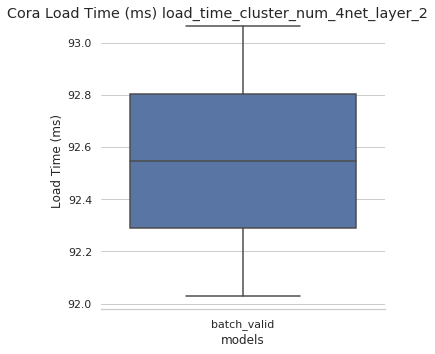

In [27]:
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, train_batch_num)

# actually we will have : train_batch_num * round_num batches!!!
step1_generate_train_batch(intermediate_data_folder, hop_layer_num, train_frac = 1.0, \
                           batch_range = (0, train_batch_num), info_folder = './info_train_batch/' )

step2_generate_validation_whole_graph(intermediate_data_folder, info_folder = './info_validation_whole/')

step3_run_train_batch(intermediate_data_folder, train_batch_num, GCN_layer, \
                trainer_id = 0, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)

step3_run_train_batch(intermediate_data_folder, train_batch_num, GCN_layer, \
                trainer_id = 1, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20)

step4_run_validation_batch(image_data_path, intermediate_data_folder, train_batch_num, net_layer_num, trainer_list = list(range(2)))

### Tune parameters

Start running for train batch num: 4

Start to generate the clustering machine:
Batch machine creation costs a total of 0.0193 seconds!

 Information about the content of ./vanilla_split_first_metis_neighbor_1/tmp/

Start to split data into train, test, validation:
Data splitting costs a total of 0.0049 seconds!
Start to store the batch machine file:
Storing batch machine after training batches generation costs a total of 0.0110 seconds!

Start running for train batch num: (0, 4)

Batch machine reading costs a total of 0.0064 seconds!
Start to generate the training batches:
*** Generate batch file for #   0 batch, writing the batch file costed 3.39 ms ***
*** Generate batch file for #   1 batch, writing the batch file costed 3.53 ms ***
*** Generate batch file for #   2 batch, writing the batch file costed 3.70 ms ***
*** Generate batch file for #   3 batch, writing the batch file costed 3.35 ms ***
Train batches production costs a total of 0.1136 seconds!

 Information about the conte

*** During training for #   0 batch, reading batch file costed 2.23 ms ***
*** During training for #   2 batch, reading batch file costed 2.25 ms ***
*** During training for #   1 batch, reading batch file costed 2.31 ms ***
*** During training for #   0 batch, reading batch file costed 2.24 ms ***
*** During training for #   1 batch, reading batch file costed 3.33 ms ***
*** During training for #   3 batch, reading batch file costed 2.07 ms ***
*** During training for #   2 batch, reading batch file costed 2.31 ms ***
Training costs a total of 6.9473 seconds!
--------------------------------------------------------------------------------
Start running training for partition num: 4

Start generate the trainer:
Trainer creation costs a total of 0.0009 seconds!
Start train the model:
*** During training for #   2 batch, reading batch file costed 2.36 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file 

*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
Training costs a total of 6.3806 seconds!
--------------------------------------------------------------------------------
Start running training for partition num: 4

Start generate the trainer:
Trainer creation costs a total of 0.0007 seconds!
Start train the model:
*** During training for #   0 batch, reading batch file costed 2.17 ms ***
*** During training for #   2 batch, reading batch file costed 2.42 ms ***
*** During training for #   3 batch, reading batch file costed 2.04 ms ***
*** During training for #   1 batch, reading batch file costed 2.24 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file 

*** During training for #   2 batch, reading batch file costed 2.66 ms ***
*** During training for #   1 batch, reading batch file costed 2.59 ms ***
*** During training for #   0 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.70 ms ***
*** During training for #   3 batch, reading batch file costed 2.40 ms ***
*** During training for #   1 batch, reading batch file costed 2.28 ms ***
*** During training for #   2 batch, reading batch file costed 2.29 ms ***
*** During training for #   1 batch, reading batch file costed 2.34 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 2.00 ms ***
*** During training for #   0 batch, reading batch file costed 2.21 ms ***
*** During training for #   1 batch, reading batch file costed 2.28 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.11 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   2 batch, reading batch file costed 2.41 ms ***
*** During training for #   1 batch, reading batch file costed 2.21 ms ***
*** During training for #   2 batch, reading batch file costed 2.81 ms ***
*** During training for #   3 batch, reading batch file costed 2.06 ms ***
*** During training for #   1 batch, reading batch file costed 2.31 ms ***
*** During training for #   0 batch, reading batch file costed 2.15 ms ***
*** During training for #   3 batch, reading batch file costed 2.21 ms ***
*** During training for #   1 batch, reading batch file costed 2.25 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 2.13 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   0 batch, reading batch file costed 2.06 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   0 batch, reading batch file costed 2.20 ms ***
*** During training for #   0 batch, reading batch file costed 2.41 ms ***
*** During training for #   1 batch, reading batch file costed 2.32 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   2 batch, reading batch file costed 2.33 ms ***
*** During training for #   3 batch, reading batch file costed 2.12 ms ***
*** During training for #   2 batch, reading batch file costed 2.22 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   1 batch, reading batch file costed 2.13 ms ***
Training costs a total of 6.6713 seconds!
--------------------------------------------------------------------------------
Start running training for partition num: 4

Start generate the trainer:
Trainer creation costs a total of 0.0006 seconds!
Start train the model:
*** During training for #   1 batch, reading batch file costed 2.20 ms ***
*** During training for #   2 batch, reading batch file costed 2.19 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 2.00 ms ***
*** During training for #   1 batch, reading batch file 

*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   2 batch, reading batch file costed 2.30 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   1 batch, reading batch file costed 2.19 ms ***
*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   1 batch, reading batch file costed 2.13 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 2.04 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.05 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.32 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
Training costs a total of

*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   2 batch, reading batch file costed 2.20 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   2 batch, reading batch file costed 2.19 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.36 ms ***
*** During training for #   2 batch, reading batch file costed 2.30 ms ***
*** During training for #   1 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   1 batch, reading batch file costed 2.24 ms ***
*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 2.00 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.11 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.06 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   3 batch, reading batch file costed 2.13 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   3 batch, reading batch file costed 2.07 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   1 batch, reading batch file costed 2.02 ms ***
*** During training for #   0 batch, reading batch file costed 2.14 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #

*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   2 batch, reading batch file costed 2.27 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.18 ms ***
*** During training for #

*** During training for #   2 batch, reading batch file costed 2.22 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file costed 2.11 ms ***
*** During training for #   0 batch, reading batch file costed 2.05 ms ***
*** During training for #   1 batch, reading batch file costed 2.23 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   2 batch, reading batch file costed 2.37 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 2.15 ms ***
*** During training for #   2 batch, reading batch file costed 2.18 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   2 batch, reading batch file costed 2.36 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   1 batch, reading batch file costed 2.00 ms ***
*** During training for #   3 batch, reading batch file costed 2.05 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   1 batch, reading batch file costed 2.02 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.25 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   3 batch, reading batch file costed 2.33 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   1 batch, reading batch file costed 2.10 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #

*** During training for #   2 batch, reading batch file costed 2.33 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   1 batch, reading batch file costed 2.17 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   2 batch, reading batch file costed 2.53 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.13 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   2 batch, reading batch file costed 2.18 ms ***
*** During training for #   1 batch, reading batch file costed 2.11 ms ***
*** During training for #   3 batch, reading batch file costed 2.03 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   0 batch, reading batch file costed 2.46 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.21 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   1 batch, reading batch file costed 2.02 ms ***
*** During training for #   0 batch, reading batch file costed 2.06 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   0 batch, reading batch file costed 2.17 ms ***
*** During training for #   2 batch, reading batch file costed 2.20 ms ***
*** During training for #   3 batch, reading batch file costed 2.21 ms ***
*** During training for #   2 batch, reading batch file costed 2.23 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.21 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 1.94 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   1 batch, reading batch file costed 2.37 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   0 batch, reading batch file costed 1.98 ms ***
*** During training for #   2 batch, reading batch file costed 2.11 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   0 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   3 batch, reading batch file costed 2.07 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   0 batch, reading batch file costed 2.06 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.11 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   0 batch, reading batch file costed 2.29 ms ***
*** During training for #   1 batch, reading batch file costed 2.17 ms ***
*** During training for #   3 batch, reading batch file costed 2.00 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 2.15 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.25 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   2 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.27 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   3 batch, reading batch file costed 2.05 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.10 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   1 batch, reading batch file costed 2.27 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 1.99 ms ***
*** During training for #   2 batch, reading batch file costed 2.22 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.23 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   1 batch, reading batch file costed 2.32 ms ***
*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.25 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.18 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.22 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.28 ms ***
*** During training for #   3 batch, reading batch file costed 1.90 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   0 batch, reading batch file costed 2.23 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #

*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   0 batch, reading batch file costed 1.99 ms ***
*** During training for #   2 batch, reading batch file costed 2.07 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 2.34 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   1 batch, reading batch file costed 2.25 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.01 ms ***
*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   1 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 1.98 ms ***
*** During training for #   1 batch, reading batch file costed 2.02 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   2 batch, reading batch file costed 2.25 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   1 batch, reading batch file costed 2.22 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 2.07 ms ***
*** During training for #   2 batch, reading batch file costed 2.06 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.33 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   2 batch, reading batch file costed 2.23 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.27 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   0 batch, reading batch file costed 2.20 ms ***
*** During training for #   2 batch, reading batch file costed 2.11 ms ***
*** During training for #   3 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.36 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   0 batch, reading batch file costed 2.13 ms ***
*** During training for #   3 batch, reading batch file costed 2.03 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   1 batch, reading batch file costed 2.13 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 2.23 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   3 batch, reading batch file costed 1.98 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.09 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.62 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   0 batch, reading batch file costed 2.21 ms ***
*** During training for #   3 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   3 batch, reading batch file costed 2.22 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.96 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.21 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   2 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.19 ms ***
*** During training for #   3 batch, reading batch file costed 1.90 ms ***
*** During training for #   0 batch, reading batch file costed 2.23 ms ***
*** During training for #   2 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 2.00 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   2 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   0 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.14 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   2 batch, reading batch file costed 2.22 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   1 batch, reading batch file costed 2.12 ms ***
*** During training for #   1 batch, reading batch file costed 2.37 ms ***
*** During training for #   2 batch, reading batch file costed 2.26 ms ***
*** During training for #   0 batch, reading batch file costed 2.22 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   3 batch, reading batch file costed 2.14 ms ***
*** During training for #   2 batch, reading batch file costed 2.16 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.23 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   0 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 2.05 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.21 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #

*** During training for #   0 batch, reading batch file costed 2.31 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 2.17 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.18 ms ***
*** During training for #   1 batch, reading batch file costed 2.15 ms ***
*** During training for #   3 batch, reading batch file costed 2.08 ms ***
*** During training for #   2 batch, reading batch file costed 2.11 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   0 batch, reading batch file costed 1.99 ms ***
*** During training for #   1 batch, reading batch file costed 2.08 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   2 batch, reading batch file costed 2.05 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   3 batch, reading batch file costed 2.19 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #   0 batch, reading batch file costed 2.07 ms ***
*** During training for #   1 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 2.08 ms ***
*** During training for #   1 batch, reading batch file costed 2.07 ms ***
*** During training for #   0 batch, reading batch file costed 2.00 ms ***
*** During training for #   2 batch, reading batch file costed 2.18 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.18 ms ***
*** During training for #   2 batch, reading batch file costed 2.15 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.24 ms ***
*** During training for #   3 batch, reading batch file costed 1.91 ms ***
*** During training for #   1 batch, reading batch file costed 2.00 ms ***
*** During training for #   2 batch, reading batch file costed 2.30 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   1 batch, reading batch file costed 2.03 ms ***
*** During training for #   0 batch, reading batch file costed 2.41 ms ***
*** During training for #   1 batch, reading batch file costed 2.02 ms ***
*** During training for #   2 batch, reading batch file costed 2.40 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 1.89 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   2 batch, reading batch file costed 2.03 ms ***
*** During training for #   3 batch, reading batch file costed 2.08 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   1 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 1.95 ms ***
*** During training for #   2 batch, reading batch file costed 2.09 ms ***
*** During training for #   0 batch, reading batch file costed 1.99 ms ***
*** During training for #   3 batch, reading batch file costed 1.92 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   1 batch, reading batch file costed 2.05 ms ***
*** During training for #   2 batch, reading batch file costed 2.07 ms ***
*** During training for #

*** During training for #   3 batch, reading batch file costed 2.07 ms ***
*** During training for #   1 batch, reading batch file costed 2.25 ms ***
*** During training for #   0 batch, reading batch file costed 2.04 ms ***
*** During training for #   2 batch, reading batch file costed 2.13 ms ***
*** During training for #   0 batch, reading batch file costed 2.11 ms ***
*** During training for #   2 batch, reading batch file costed 2.12 ms ***
*** During training for #   3 batch, reading batch file costed 2.10 ms ***
*** During training for #   1 batch, reading batch file costed 2.09 ms ***
*** During training for #   3 batch, reading batch file costed 1.97 ms ***
*** During training for #   2 batch, reading batch file costed 2.17 ms ***
*** During training for #   0 batch, reading batch file costed 2.08 ms ***
*** During training for #   1 batch, reading batch file costed 2.14 ms ***
*** During training for #   2 batch, reading batch file costed 2.10 ms ***
*** During training for #

*** During training for #   1 batch, reading batch file costed 2.26 ms ***
*** During training for #   0 batch, reading batch file costed 2.02 ms ***
*** During training for #   3 batch, reading batch file costed 2.01 ms ***
*** During training for #   0 batch, reading batch file costed 2.01 ms ***
*** During training for #   3 batch, reading batch file costed 1.94 ms ***
*** During training for #   2 batch, reading batch file costed 2.05 ms ***
*** During training for #   1 batch, reading batch file costed 2.06 ms ***
*** During training for #   3 batch, reading batch file costed 2.11 ms ***
*** During training for #   2 batch, reading batch file costed 2.03 ms ***
*** During training for #   1 batch, reading batch file costed 2.12 ms ***
*** During training for #   0 batch, reading batch file costed 1.99 ms ***
*** During training for #   3 batch, reading batch file costed 1.93 ms ***
*** During training for #   2 batch, reading batch file costed 2.37 ms ***
*** During training for #

*** During validation for # whole graph batch, reading batch file costed 4.66 ms ***
Validatoin costs a total of 0.0161 seconds!
Start running training for partition num: 4
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer costs a total of 1.4710 seconds!
Start validate the model:
*** During validation for # whole graph batch, reading batch file costed 4.40 ms ***
Validatoin costs a total of 0.0104 seconds!
Start running training for partition num: 4
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer costs a total of 1.3819 seconds!
Start validate the model:
*** During validation for # whole graph batch, reading batch file costed 4.34 ms ***
Validatoin costs a total of 0.0101 seconds!
Start running training for partition num: 4
Start to read the GCN trainer model (parameters: weights, bias):
Reading the trainer costs a total of 1.5588 seconds!
Start validate the model:
*** During validation for # whole graph batch, re

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 432x288 with 0 Axes>

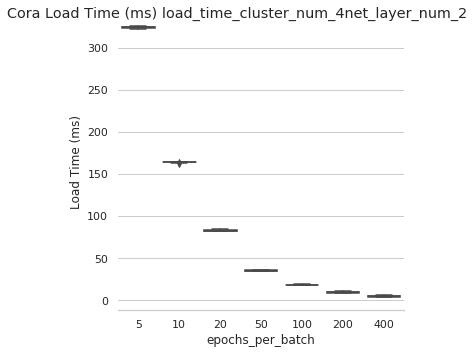

In [31]:
step0_generate_clustering_machine(data, dataset, intermediate_data_folder, train_batch_num)

step1_generate_train_batch(intermediate_data_folder, hop_layer_num, train_frac = 1.0, \
                           batch_range = (0, train_batch_num), info_folder = 'info_train_batch/' )

step2_generate_validation_whole_graph(intermediate_data_folder, info_folder = 'info_validation_whole/')

for tune_val in tune_val_list:
    for trainer_id in trainer_list:
        step30_run_tune_train_batch(intermediate_data_folder, tune_param_name, tune_val, train_batch_num, GCN_layer, \
                            trainer_id = trainer_id, dropout = 0.1, lr = 0.0001, weight_decay = 0.1, mini_epoch_num = 20, epoch_num = 400)
        
for tune_val in tune_val_list:
    for trainer_id in trainer_list:
        step40_run_tune_validation_whole(image_data_path, intermediate_data_folder, tune_param_name, tune_val, train_batch_num, net_layer_num, \
                            trainer_id = trainer_id)

step50_run_tune_summarize_whole(data_name, image_data_path, intermediate_data_folder, tune_param_name, tune_val_list, \
                                train_batch_num, net_layer_num, trainer_list)

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './'
partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64]]

### CoraFull dataset

In [ ]:
from torch_geometric.datasets import CoraFull
data_name = 'CoraFull'
dataset = CoraFull(root = local_data_root + 'CoralFull')
print('number of data: ', len(dataset))
data = dataset[0]

image_data_path = './results/' + data_name + '/' + test_folder_name
intermediate_data_folder = './intermediate_data/' + data_name + '/' + test_folder_name

partition_nums = [4]
layers = [[128, 128]]
tune_lr = 0.0001
check_mini_epoch = 20

### CiteSeer Dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'CiteSeer'
dataset = Planetoid(root = local_data_root + 'Planetoid/CiteSeer', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [16], [16, 16]]

### Tuning the epoch number per batch

#### Checking train loss

### PubMed dataset

In [ ]:
from torch_geometric.datasets import Planetoid
data_name = 'PubMed'
dataset = Planetoid(root = local_data_root + 'Planetoid/PubMed', name=data_name)
data = dataset[0]
image_data_path = './results/' + data_name + '/' + test_folder_name

partition_nums = [2, 4, 8]
layers = [[], [64], [64, 64], [64, 64, 64]]

#### Tune epoch number per batch

### Check the train error

### Appendix

In [ ]:
# free GPU memory
# !(nvidia-smi | grep 'python' | awk '{ print $3 }' | xargs -n1 kill -9)
# torch.cuda.empty_cache()